In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

import math
from sklearn.model_selection import train_test_split
import pickle

pd.options.display.float_format = '{:20,.2f}'.format # formatting

## Load Data

In [ ]:
## Initial load
# Loading features data 
path = r'./data/features/'
all_files = glob.glob(path + "/*.csv")
df = pd.concat(pd.read_csv(f) for f in all_files)

# Loading the labels file
labels = pd.read_csv("./data/labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv")

In [4]:
# ## Subsequent loads
# # load features data ; change file path accordingly
# fpath = "../data/features/sorted.pkl"
# data = pickle.load(open(fpath,'rb'))
# labels = pd.read_csv("../data/labels/cleaned_labels.csv", index_col=0)

### Data Cleaning
1. Remove duplicate bookingIDs from both datasets
2. Remove Inaccurate features data
3. Impute missing records

In [ ]:
unique_labels = datalabels.bookingID.value_counts()
duplicates = labels.loc[labels.bookingID.duplicated(),'bookingID']

print("There are {} unique labels, \
but a total of {} records in the labels dataset. \
This corresponds to {} records in the features dataset.".format(
    len(unique_labels), 
    len(labels), 
    df.loc[df.bookingID.isin(duplicates),'bookingID'].value_counts().sum()))

In [ ]:
# Remove duplicates from both datasets
df_clean = df[~df.bookingID.isin(duplicates.bookingID)].copy()
labels_clean = labels[~labels.bookingID.isin(duplicates.bookingID)].copy()
labels_clean.to_csv("./data/labels/cleaned_labels.csv", index = False)

In [ ]:
# Check if duplicates still exist in the features dataset
duplicated_seconds = df_clean[df_clean.duplicated(['bookingID','second'])]
print(len(duplicated_seconds))

#### Inaccurate Data
When the `Accuracy` recorded in the features dataset gets too high, we notice that the `Speed` of the row can become -1, or the recorded `Second` can become extremely large. This is likely due to the GPS on the phone losing connectivity(e.g. due to car being in tunnels). Such records should be removed first. We will later impute this with the other missing records.

In [36]:
data.columns

Index(['bookingID', 'Accuracy', 'Bearing', 'acceleration_x', 'acceleration_y',
       'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z', 'second', 'Speed'],
      dtype='object')

In [66]:
print('% of data with speed < -1 ')
print(len(data[data.Speed < 0]) / len(data) * 100)
data[(data.Speed < 0) & (data.Accuracy > 20)].head(20)

% of data with speed < -1 
1.4894670771393457


,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
1519100,0,48.000,283.080139,-3.170016,-9.607098,1.037930,-0.072483,0.051266,-0.084960,1200.0,-1.0
774049,26,24.499,0.000000,-0.411815,10.024829,-0.641666,0.035979,0.061432,-0.127477,405.0,-1.0
618524,28,600.000,0.000000,0.067040,8.937828,0.931373,-0.124507,-0.050253,0.049703,689.0,-1.0
840745,28,759.360,0.000000,-0.545895,10.515655,-1.367131,0.106400,0.060924,-0.048035,736.0,-1.0
557125,28,1027.026,0.000000,0.747014,9.976943,1.055875,0.051422,-0.044145,-0.008329,782.0,-1.0
1551418,28,1375.983,0.000000,-0.428575,9.778218,2.061470,0.021490,0.027326,-0.038872,826.0,-1.0
572076,39,45.765,0.000000,-0.318439,5.700768,1.747821,-0.398280,0.078687,0.006862,597.0,-1.0
1157729,47,41.707,0.000000,0.952892,5.462970,7.981670,0.000799,-0.107059,-0.210656,0.0,-1.0
61080,47,41.707,0.000000,-0.287304,5.434239,7.253833,-0.024767,0.005326,0.047671,40.0,-1.0
877738,47,25.606,0.000000,0.244209,6.885126,8.245032,0.042078,0.038083,0.022637,60.0,-1.0


In [46]:
data_negspeedremoved = data[data.Speed >= 0].copy()

In [50]:
len(data_negspeedremoved)

15876651

173546     0.0
1072483    1.0
839340     2.0
835391     3.0
1602065    4.0
Name: second, dtype: float64


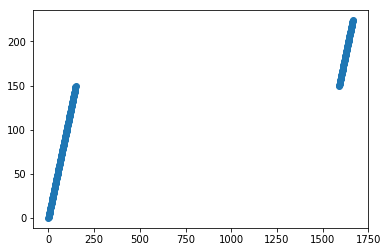

In [94]:
id = 120259084406
print(data_negspeedremoved[data_negspeedremoved.bookingID == id].second.head())
plt.scatter(data_negspeedremoved[data_negspeedremoved.bookingID == id].second,
            np.arange(0,len(data_negspeedremoved[data_negspeedremoved.bookingID == id])))

In [74]:
def missing_elements(L):
    start, end = L[0], L[-1]
    return sorted(set(range(start, end + 1)).difference(L))

ls = list(data_negspeedremoved[data_negspeedremoved.bookingID == id].second.astype('int'))
missing_elements(ls)

In [67]:
temp = pd.DataFrame({'N.Records':data_negspeedremoved.groupby('bookingID').second.count(),'MaxRecord':data_negspeedremoved.groupby('bookingID').second.max()})
temp.MaxRecord = temp.MaxRecord.astype('int')
# add column of "largest gap?"

print('% of bookingID where there are missing records')
print(len(temp[temp['N.Records']<temp['MaxRecord']]) / len(temp) * 100)
temp[temp['N.Records']<temp['MaxRecord']]

% of bookingID where there are missing records
73.19969932347783


,N.Records,MaxRecord
bookingID,,
0,1003,1589
1,838,1034
2,195,825
7,949,959
8,385,462
11,225,299
14,598,599
16,646,659
17,606,614


In [29]:
temp['%Diff'] = (temp['MaxRecord'] - temp['N.Records']) / temp['MaxRecord'] * 100

In [34]:
len(temp[temp['%Diff']<= 90]) /len(temp) * 100

99.92493243919527

In [ ]:

# data_negspeedremoved.pivot()
# np.diff() 

In [9]:
data.groupby('bookingID').count().head(20)

,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
bookingID,,,,,,,,,,
0,1004,1004,1004,1004,1004,1004,1004,1004,1004,1004
1,851,851,851,851,851,851,851,851,851,851
10,375,375,375,375,375,375,375,375,375,375
1005022347266,840,840,840,840,840,840,840,840,840,840
1005022347267,740,740,740,740,740,740,740,740,740,740
1005022347268,428,428,428,428,428,428,428,428,428,428
1005022347269,1595,1595,1595,1595,1595,1595,1595,1595,1595,1595
1005022347271,420,420,420,420,420,420,420,420,420,420
1005022347275,630,630,630,630,630,630,630,630,630,630


In [69]:
# Using 10% of the data first
df_mini = data.head(int(len(data)*0.1)).copy()
df_mini = df_mini.reset_index()

# ensure that the last value we chop off is a complete bookingID's 
lastval = df_mini[(df_mini.bookingID==df_mini.iloc[-1,1]) & (df_mini.second == 0.00)].index[0]
df_mini = df_mini.iloc[:lastval,:]
df_mini.drop('index',inplace=True, axis=1)
len(df_mini)

1611105

In [64]:
df_mini.tail(20)
df_mini.head(20)

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454
5,0,8.0,143.298294,-0.608313,-9.539658,-1.794583,-0.007538,-0.023838,0.018068,5.0,0.228454
6,0,8.0,143.298294,-0.867758,-9.698615,-1.615439,0.022728,-0.012178,0.005982,6.0,0.228454
7,0,8.0,143.298294,-1.050790,-9.745270,-1.411771,0.027603,0.001841,0.000904,7.0,0.228454
8,0,8.0,143.298294,-0.721213,-9.960004,-1.202271,0.001864,-0.007702,0.014018,8.0,0.228454
9,0,8.0,143.298294,-0.346924,-9.532629,-1.204663,0.014962,-0.050033,0.025118,9.0,0.228454


In [130]:
df_totrain = data.groupby('bookingID').agg(['mean','std','min','max'])

In [49]:
# labels.drop('Unnamed: 0',inplace=True,axis=1) # Needed if index column is passed to csv 
labels.sort_values('bookingID',inplace=True)

In [85]:
startoftrip = data[data.second == 0]
startoftrip.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
1153972,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991
212430,1,4.0,252.000000,-1.394632,10.174141,-2.503770,0.016127,0.212284,-0.039776,0.0,4.756427
1312695,10,3.0,0.000000,0.928955,9.296692,-1.161194,-0.013931,-0.007431,0.006516,0.0,0.000000
75086,1005022347266,3.0,95.000000,-0.906225,9.547540,-1.969930,0.009390,0.004643,-0.003595,0.0,0.000000
1049487,1005022347267,3.9,181.000000,0.683411,10.746094,2.123398,0.007446,0.011063,-0.017456,0.0,22.760000


In [104]:
labels_id = labels.bookingID 
data_id = data.bookingID.unique()
len(labels_id), len(data_id)

In [114]:
data.groupby('bookingID').second.count().head(20)

bookingID
0                1004
1                 851
10                375
1005022347266     840
1005022347267     740
1005022347268     428
1005022347269    1595
1005022347271     420
1005022347275     630
1005022347277    1050
1005022347279     630
1005022347280     225
1005022347282     839
1005022347284    1045
1005022347285     327
1005022347289    1485
1005022347291     522
1005022347293    1394
1005022347294     443
1005022347296    1015
Name: second, dtype: int64

In [119]:
# Cleaning: records with sudden jump in recorded seconds 
data[data.second > 10000].groupby('bookingID').count()

,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
bookingID,,,,,,,,,,
1108101562401,3,3,3,3,3,3,3,3,3,3
1434519076976,2,2,2,2,2,2,2,2,2,2
1460288880770,32,32,32,32,32,32,32,32,32,32
1503238553722,1,1,1,1,1,1,1,1,1,1
858993459333,44,44,44,44,44,44,44,44,44,44


In [129]:
# individual to analyze; change bookingID as needed
indiv_data = data[data.bookingID == '858993459333']
print(len(indiv_data))
indiv_data.sort_values('second').head(20)

504


,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
435937,858993459333,12.000,353.0,-0.632069,9.643845,3.122039,-0.051007,0.028100,0.082161,0.0,5.358241
1311796,858993459333,12.000,353.0,-0.670377,9.567230,3.677494,-0.037263,0.045509,0.014966,1.0,5.141538
162552,858993459333,10.077,354.0,-0.756568,9.643845,3.198653,-0.056505,0.022602,0.028711,2.0,2.623132
181512,858993459333,10.011,354.0,-0.306458,9.653421,1.628057,-0.048564,0.032070,0.028100,3.0,0.000000
487156,858993459333,9.963,354.0,-0.191536,9.816227,1.292869,-0.030238,0.025351,0.025045,4.0,0.000000
950959,858993459333,9.930,354.0,-0.354342,9.883265,0.258574,-0.050396,0.045815,0.019853,5.0,0.000000
1328550,858993459333,9.905,354.0,2.078167,11.013328,5.631162,-0.079107,-0.039095,-0.001222,6.0,0.000000
877628,858993459333,10.240,358.0,0.363919,9.950302,0.124498,-0.106291,-0.214414,0.046120,7.0,3.194665
516470,858993459333,10.226,14.0,0.737414,10.180145,1.628057,0.028100,-0.257785,-0.017410,8.0,3.194665
1532722,858993459333,10.193,33.0,1.829170,9.825804,1.331176,-0.028100,-0.432493,0.013744,9.0,2.101302


## Save the cleaned data

In [ ]:
df_sorted.to_pickle('./data/features/sorted.pkl')